In [1]:
import sys
import warnings
import itertools
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.graphics.tsaplots     import  plot_pacf
from statsmodels.graphics.tsaplots     import  plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error

from datetime import datetime,timedelta

import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train_df = pd.read_csv("train.csv",parse_dates=['Month'],index_col='Month')
train_df.head()

,Avg_sunspot_count
Month,
1749-01-01,97
1749-02-01,104
1749-03-01,117
1749-04-01,93
1749-05-01,142


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3144 entries, 1749-01-01 to 2010-12-01
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Avg_sunspot_count  3144 non-null   int64
dtypes: int64(1)
memory usage: 49.1 KB


In [4]:
train_df.isnull().sum()

Avg_sunspot_count    0
dtype: int64

<Axes: xlabel='Month'>

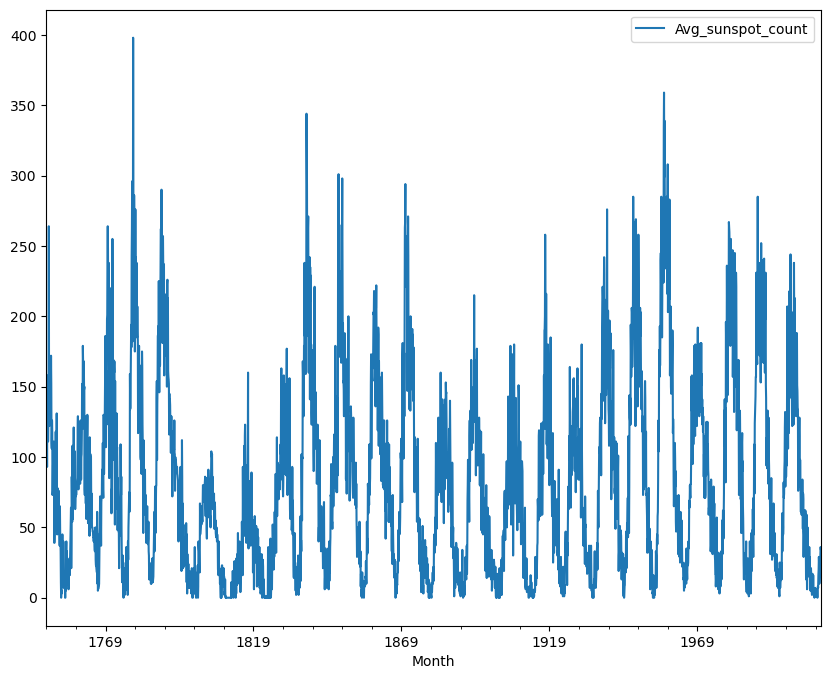

In [5]:
plt.rcParams['figure.figsize'] = 10,8
train_df.plot()

In [6]:
train_df.shape

(3144, 1)

In [7]:
test_df = pd.read_csv("test.csv",parse_dates=['Month'],index_col='Month')
test_df.head()

""
Month
2011-01-01
2011-02-01
2011-03-01
2011-04-01
2011-05-01


In [8]:
test_df.shape

(120, 0)

[]

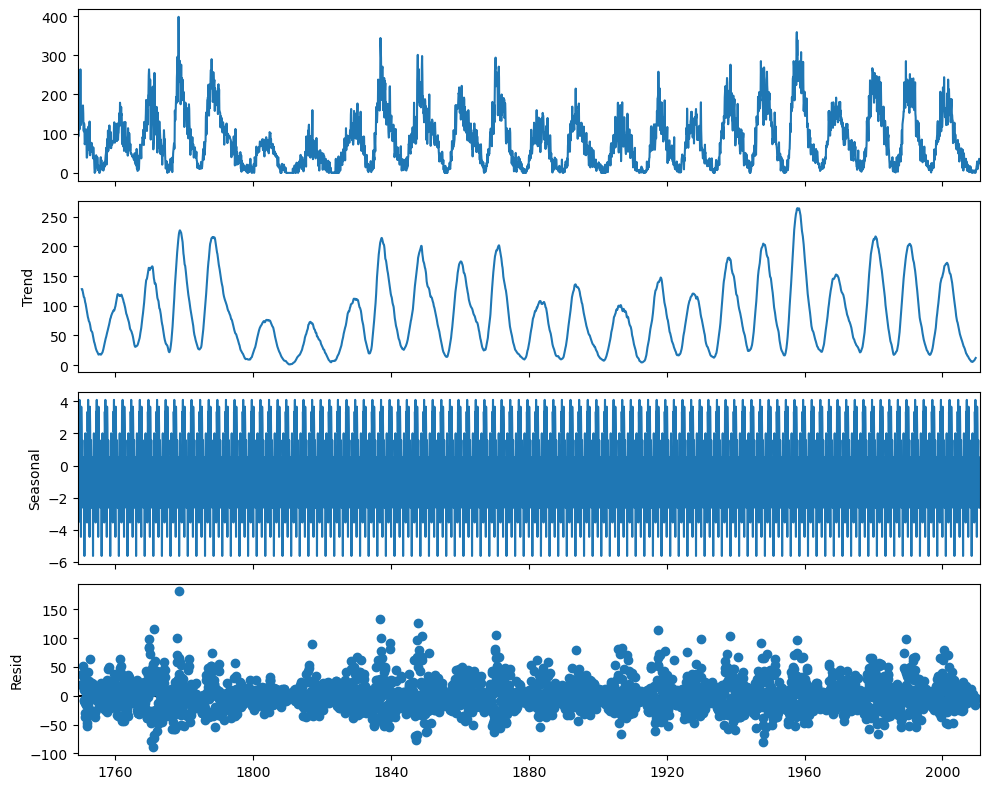

In [9]:
#Decompose time series

decomposition = seasonal_decompose(train_df,model='additive',period=30)
decomposition.plot()
plt.plot()

There is a trend but no seasonality present.The model is additive in nature

In [10]:
#Stationarity test

observations = train_df.values
result = adfuller(observations)

In [11]:
result

(-10.390308589912841,
 2.0290768019122118e-18,
 28,
 3115,
 {'1%': -3.43245102630828,
  '5%': -2.862468302843017,
  '10%': -2.5672641578701927},
 28786.33743096589)

p-value<0.05,therefore the data is stationary

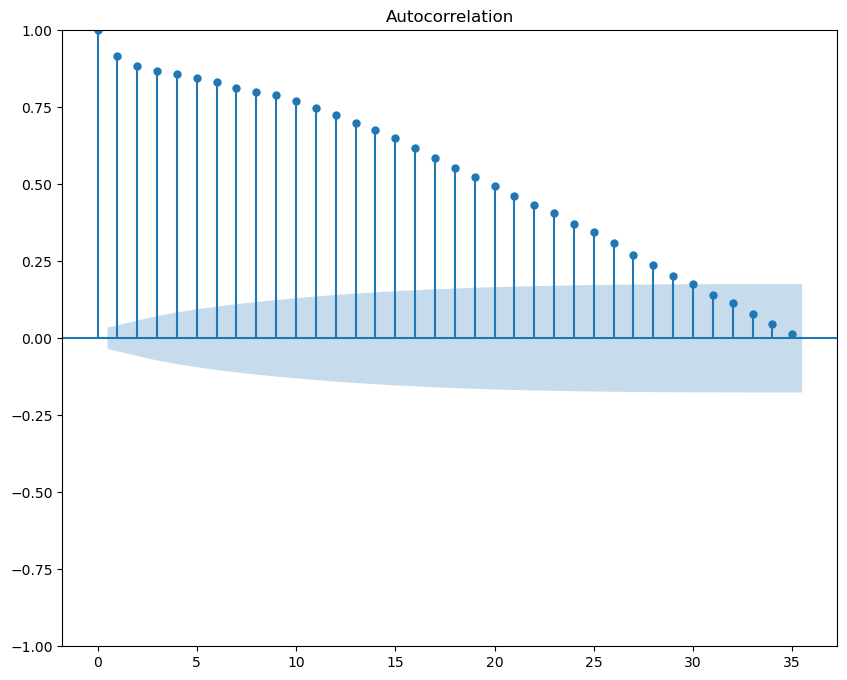

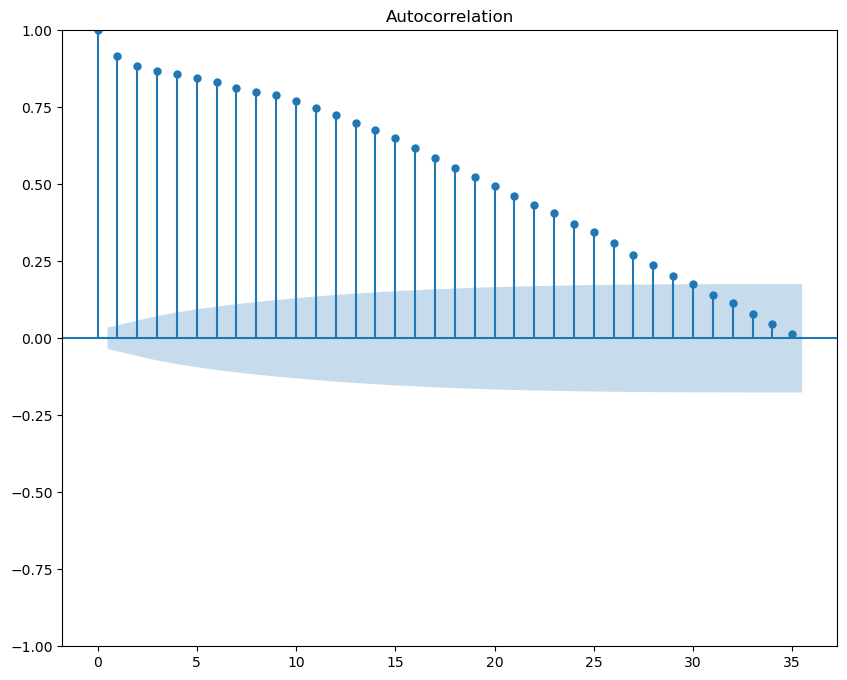

In [12]:
#ACF and PACF

plot_acf(train_df)

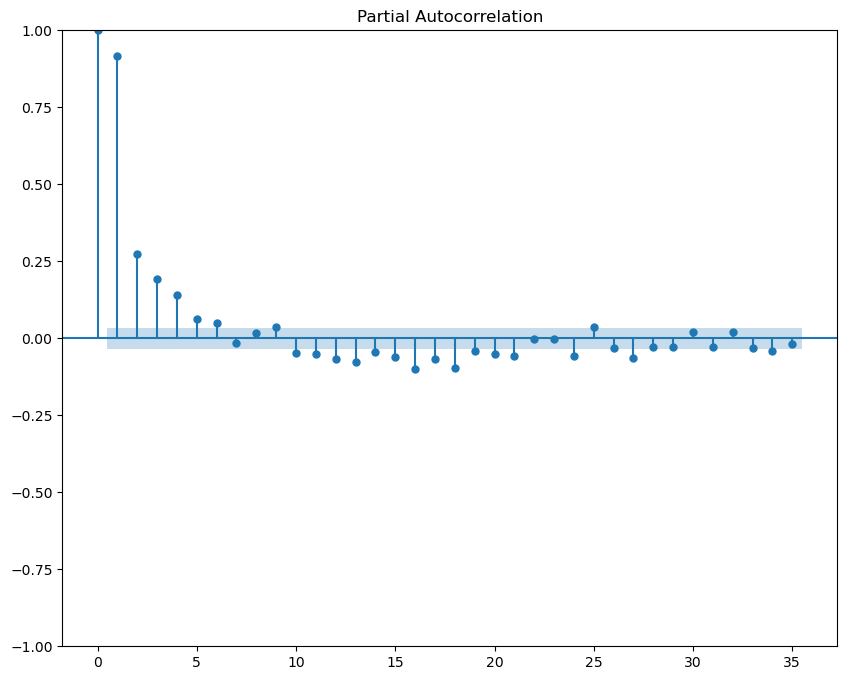

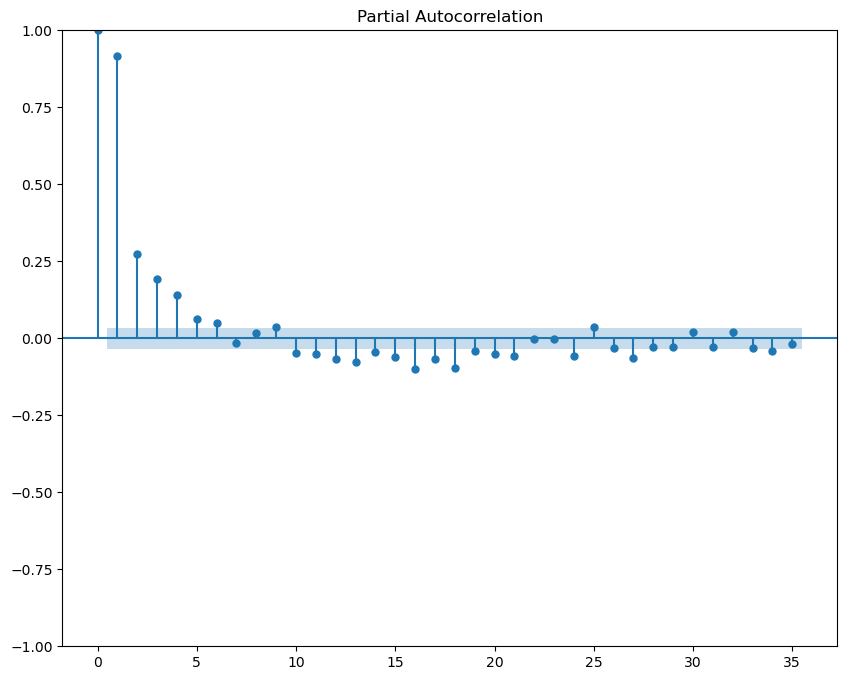

In [13]:
plot_pacf(train_df)

p=4
q=28

In [14]:
# Ensure the DataFrame index is of DateTime type
train_df.index = pd.to_datetime(train_df.index)

In [15]:
#Split the data
#For Validation

train_end = datetime(2005,8,31)
test_end = datetime(2010,12,31)

In [16]:
train = train_df[:train_end]
test = train_df[train_end+pd.DateOffset(months=1):test_end]

In [17]:
test.tail()

,Avg_sunspot_count
Month,
2010-08-01,30
2010-09-01,36
2010-10-01,34
2010-11-01,34
2010-12-01,25


In [18]:
#Fit ARMA model
model_arma=ARIMA(train,order=(1,0,5))
model_arma_fit=model_arma.fit()
print(model_arma_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      Avg_sunspot_count   No. Observations:                 3080
Model:                 ARIMA(1, 0, 5)   Log Likelihood              -14351.071
Date:                Thu, 06 Jun 2024   AIC                          28718.143
Time:                        09:16:03   BIC                          28766.404
Sample:                    01-01-1749   HQIC                         28735.479
                         - 08-01-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         84.3968     15.254      5.533      0.000      54.500     114.294
ar.L1          0.9808      0.004    243.141      0.000       0.973       0.989
ma.L1         -0.4095      0.014    -28.407      0.0

In [19]:
# Forecast for 2011 to 2020
start_forecast = test_end + pd.DateOffset(months=1)
end_forecast = datetime(2020, 12, 31)

In [20]:
# Calculate the number of steps (months) to forecast
num_months = (end_forecast.year - start_forecast.year) * 12 + end_forecast.month - start_forecast.month + 1

In [21]:
# Print the start and end forecast dates
print("Start Forecast Date:", start_forecast)
print("End Forecast Date:", end_forecast)

Start Forecast Date: 2011-01-31 00:00:00
End Forecast Date: 2020-12-31 00:00:00


In [22]:
# Debug: Print the head and tail of the DataFrame
print("DataFrame Head:")
print(train_df.head())
print("DataFrame Tail:")
print(train_df.tail())

DataFrame Head:
            Avg_sunspot_count
Month                        
1749-01-01                 97
1749-02-01                104
1749-03-01                117
1749-04-01                 93
1749-05-01                142
DataFrame Tail:
            Avg_sunspot_count
Month                        
2010-08-01                 30
2010-09-01                 36
2010-10-01                 34
2010-11-01                 34
2010-12-01                 25


In [23]:
# Forecasting
forecast = model_arma_fit.get_forecast(steps=num_months)

In [24]:
# Extract forecasted values and confidence intervals
forecasted_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()


In [25]:
# Convert forecasted values to a DataFrame for easier handling
forecast_dates = pd.date_range(start=start_forecast, periods=num_months, freq='M')


In [26]:
#  Print the forecast dates
#print("Forecast Dates:")
#print(forecast_dates)

In [27]:
# Predict on the test set
prediction = model_arma_fit.get_prediction(start=test.index[0], end=test.index[-1])
predicted_values = prediction.predicted_mean
#confidence_intervals = prediction.conf_int()

In [28]:

prediction_df = pd.DataFrame({'Predicted': predicted_values}, index=test.index)

# Evaluate the predictions
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, predicted_values)
mse = mean_squared_error(test, predicted_values)
rmse = mse ** 0.5

# Debug: Print evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Print the prediction DataFrame
print(prediction_df)

Mean Absolute Error (MAE): 55.48350974223618
Mean Squared Error (MSE): 3304.2239326988256
Root Mean Squared Error (RMSE): 57.48237932357033
            Predicted
Month                
2005-10-01  60.210866
2005-11-01  60.929076
2005-12-01  61.640910
2006-01-01  62.136783
2006-02-01  62.565283
...               ...
2010-08-01  76.754240
2010-09-01  76.901358
2010-10-01  77.045643
2010-11-01  77.187151
2010-12-01  77.325935

[63 rows x 1 columns]


# Define the p, d, q ranges
p_values = range(0, 5)
d_values = [0]
q_values = range(0, 29)

best_aic, best_cfg = float("inf"), None

# Grid search for ARIMA hyperparameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Define and fit the ARIMA model
                model_arma = ARIMA(train, order=(p, d, q))
                model_arma_fit = model_arma.fit()
                
                # Get the AIC value
                aic = model_arma_fit.aic
                
                if aic < best_aic:
                    best_aic, best_cfg = aic, (p, d, q)
                    
                print(f'ARIMA{(p, d, q)} AIC={aic}')
                
            except Exception as e:
                print(f'ARIMA{(p, d, q)}: Failed with exception: {e}')
                continue

print(f'Best ARIMA{best_cfg} AIC={best_aic}')

# Fit the best ARIMA model
best_p, best_d, best_q = best_cfg
best_model_arma = ARIMA(train, order=(best_p, best_d, best_q))
best_model_arma_fit = best_model_arma.fit()
print(best_model_arma_fit.summary())

# Predict on the test set with the best model
best_prediction = best_model_arma_fit.get_prediction(start=test.index[0], end=test.index[-1])
best_predicted_values = best_prediction.predicted_mean




In [29]:
#Validation

In [30]:
# Fit the best ARIMA model
#best_p, best_d, best_q = best_cfg
best_model_arma = ARIMA(train, order=(2, 0, 1))
best_model_arma_fit = best_model_arma.fit()
print(best_model_arma_fit.summary())

# Predict on the test set with the best model
best_prediction = best_model_arma_fit.get_prediction(start=test.index[0], end=test.index[-1])
best_predicted_values = best_prediction.predicted_mean

# Convert predicted values to a DataFrame for easier handling
prediction_df = pd.DataFrame({'Predicted': best_predicted_values}, index=test.index)

                               SARIMAX Results                                
Dep. Variable:      Avg_sunspot_count   No. Observations:                 3080
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -14357.342
Date:                Thu, 06 Jun 2024   AIC                          28724.684
Time:                        09:16:05   BIC                          28754.848
Sample:                    01-01-1749   HQIC                         28735.519
                         - 08-01-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         84.3965     15.727      5.366      0.000      53.572     115.221
ar.L1          1.1901      0.030     39.144      0.000       1.131       1.250
ar.L2         -0.2042      0.029     -7.038      0.0

In [31]:
# Evaluate the predictions
mae = mean_absolute_error(test, best_predicted_values)
mse = mean_squared_error(test, best_predicted_values)
rmse = mse ** 0.5

# Print evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Print the prediction DataFrame
print(prediction_df)

Mean Absolute Error (MAE): 54.5545574223642
Mean Squared Error (MSE): 3199.985322374245
Root Mean Squared Error (RMSE): 56.568412761666245
            Predicted
Month                
2005-10-01  60.141865
2005-11-01  60.513356
2005-12-01  60.926725
2006-01-01  61.342805
2006-02-01  61.753559
...               ...
2010-08-01  75.831070
2010-09-01  75.983887
2010-10-01  76.133978
2010-11-01  76.281391
2010-12-01  76.426174

[63 rows x 1 columns]


In [32]:
# Define the training period endpoint
train_end_final = datetime(2010, 12, 31)

# Split the data
train_final = train_df[:train_end_final]

In [33]:
test_df=pd.read_csv("test.csv",index_col='Month')
test_df.head()

""
Month
01-01-2011
02-01-2011
03-01-2011
04-01-2011
05-01-2011


In [34]:
# Fit the ARIMA model with the best parameters found
best_model_arma = ARIMA(train_final, order=(2, 0, 1))  # Use the best parameters
best_model_arma_fit = best_model_arma.fit()
print(best_model_arma_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      Avg_sunspot_count   No. Observations:                 3144
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -14629.285
Date:                Thu, 06 Jun 2024   AIC                          29268.570
Time:                        09:16:07   BIC                          29298.836
Sample:                    01-01-1749   HQIC                         29279.430
                         - 12-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.9893     15.927      5.211      0.000      51.774     114.205
ar.L1          1.1918      0.030     39.994      0.000       1.133       1.250
ar.L2         -0.2056      0.028     -7.221      0.0

In [35]:
best_prediction = best_model_arma_fit.get_forecast(steps=len(test_df))
best_predicted_values = best_prediction.predicted_mean

In [36]:
best_predictions = best_model_arma_fit.predict(start=test_df.index[0], end=test_df.index[-1])

In [37]:
# Combine the month and predicted values into a DataFrame
prediction_sunspot_count1 = pd.DataFrame({'Month': test_df.index, 
                              'Avg_sunspot_count': best_predictions})

prediction_sunspot_count1.to_csv('submission.csv', index=False)

In [38]:
from statsmodels.tsa.holtwinters import Holt

# Fit double exponential smoothing model
model = Holt(train_final)
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                              Holt Model Results                              
Dep. Variable:      Avg_sunspot_count   No. Observations:                 3144
Model:                           Holt   SSE                        2101534.974
Optimized:                       True   AIC                          20459.492
Trend:                       Additive   BIC                          20483.705
Seasonal:                        None   AICC                         20459.519
Seasonal Periods:                None   Date:                 Thu, 06 Jun 2024
Box-Cox:                        False   Time:                         09:16:08
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5235714                alpha                 True
smoothing_trend            0.0168894                

In [39]:
# Predict on the test data
predictions = model_fit.predict(start=len(train_final), end=len(train_final) + len(test_df) - 1)

# Print the predictions
print(predictions)

2011-01-01    28.518441
2011-02-01    28.258133
2011-03-01    27.997825
2011-04-01    27.737517
2011-05-01    27.477209
                ...    
2020-08-01    -1.416997
2020-09-01    -1.677305
2020-10-01    -1.937613
2020-11-01    -2.197921
2020-12-01    -2.458229
Freq: MS, Length: 120, dtype: float64


In [40]:
# Get predicted values for the test data
predicted_values1 = model_fit.predict(start=0, end=len(test_df)-1)

# Print the predicted values
print(predicted_values1)

1749-01-01    104.000000
1749-02-01    107.273100
1749-03-01    112.468555
1749-04-01    121.790318
1749-05-01    113.411170
                 ...    
1758-08-01     79.656552
1758-09-01     73.138113
1758-10-01     90.724733
1758-11-01     77.391909
1758-12-01     75.704234
Freq: MS, Length: 120, dtype: float64


In [41]:

prediction_sunspot_ex = pd.DataFrame({'Month': test_df.index, 
                                          'Avg_sunspot_count': predictions})

# Save the predictions to a CSV file
prediction_sunspot_ex.to_csv('submission1.csv', index=False)